In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
data = pd.read_csv("data/processed.csv")

# Also MinMax-scaling what will be target; but saving orig. min and
#  max so we can rescale later:
omin, omax = data["SalePrice"].min(), data["SalePrice"].max()
data["SalePrice"] = minmax_scale(data["SalePrice"])

target = "SalePrice"
features = data.drop(target, axis=1).columns.tolist()

In [7]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2)

## Model

Hyperparameter tuning:

In [10]:
xgb = XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=5,  # 3-fold cross-validation
    scoring="neg_root_mean_squared_error",
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


## Model evaluation

In [12]:
xgb_best = grid_search.best_estimator_
y_hat_test = xgb_best.predict(X_test)

In [14]:
metrics = collect_metrics(y_test, y_hat_test)
metrics

{'MSE': 0.0014242021721333528,
 'RMSE': 0.037738603208562885,
 'MAE': 0.021421387316369722,
 'R-squared': 0.8792259670011534}

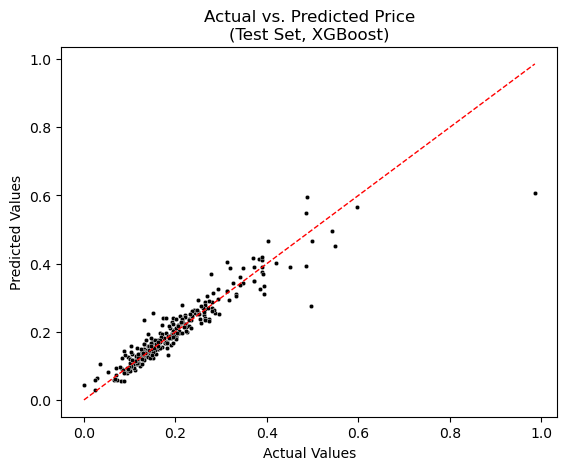

In [15]:
sns.scatterplot(x=y_test, y=y_hat_test, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test))
max_val = max(max(y_test), max(y_hat_test))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Price\n(Test Set, XGBoost)")
plt.show()


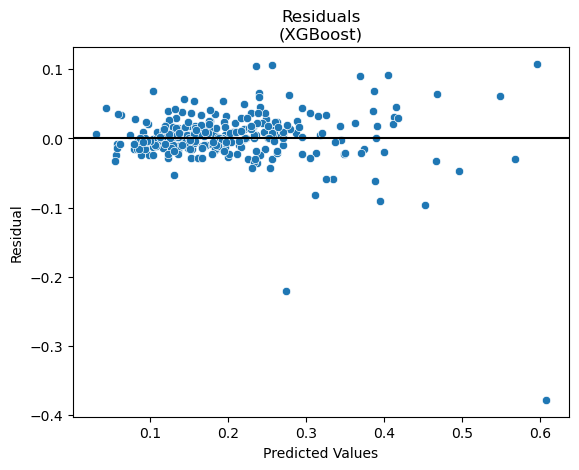

In [16]:
error_xgb = y_hat_test - y_test
sns.scatterplot(x=y_hat_test, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

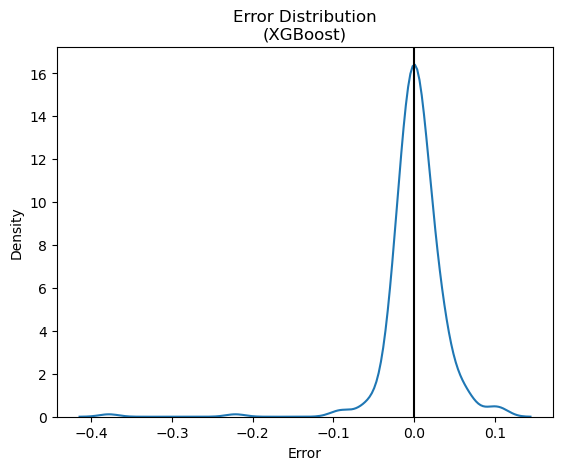

In [17]:
sns.kdeplot(error_xgb)
plt.axvline(x=0, color="black")
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Error Distribution\n(XGBoost)')
plt.show()

Text(0.5, 1.0, 'Top 10 most important features\n(XGBoost)')

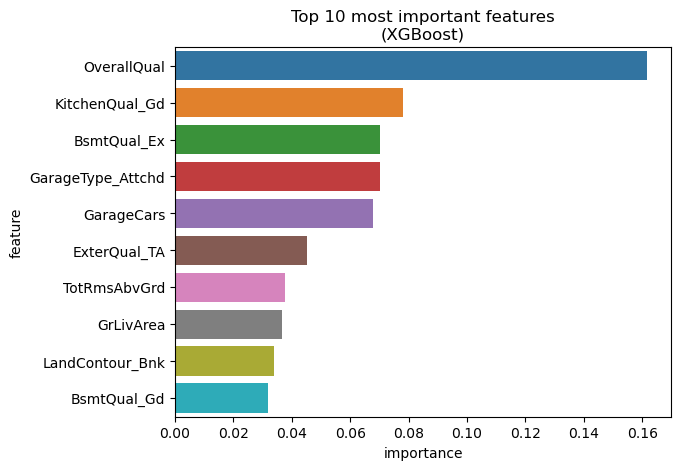

In [18]:
feature_imp = pd.DataFrame({"feature": features, "importance": xgb_best.feature_importances_})
top10_feats = feature_imp.sort_values("importance", ascending=False)[:10]

sns.barplot(
    data=top10_feats,
    x="importance",
    y="feature"
)
plt.title("Top 10 most important features\n(XGBoost)")